<a href="https://colab.research.google.com/github/a151815058/Buy-Til-You-Die-Predict-Customer-Lifetime-Value-jourdeness/blob/main/Buy_%E2%80%98Til_You_Die_Predict_Customer_Lifetime_Value_jourdeness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install Lifetimes

     |████████████████████████████████| 584 kB 4.6 MB/s 


In [2]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.7/dist-packages/matplotlib//mpl-data/fonts/ttf

--2022-02-22 05:19:16--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.210.138, 173.194.210.101, 173.194.210.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.210.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v4f5g7be49f88ketqhd1o9evmlu0asi9/1645507125000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2022-02-22 05:19:21--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v4f5g7be49f88ketqhd1o9evmlu0asi9/1645507125000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 172.217.193.132, 2607:f8b0:400c:c03::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|172.217.1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from datetime import timedelta,datetime
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.0f}'.format

# 自定義字體變數
myfont = FontProperties(fname=r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')


# 1. Wrangling

In [4]:
df0 = pd.read_csv("/content/drive/MyDrive/Classroom/論文/題目 - 探討甚麼樣價值的服務與甚麼樣的產品關聯性較強/DATA/sales_data.csv")

In [5]:
df0

,sales_no,categorydescription,categorydescription1,stock_id,stock_description,sales_qty,sale_date,unit_price,member_code,name,member_start_date,first_trans_date
0,PS5339001945,系統用,前臺收款,ZFE02,工本費,1,2018-11-01,350,"9,100,000,071,084",中區,2000-12-15,2012-07-19
1,PS5352014501,產品正貨,精油,JZA4G2,輕鬆．清新複方按摩油30ml,1,2018-11-01,282,"9,100,002,151,296",中區,2016-04-28,2016-04-25
2,PS5352014501,臉部主課程,不分版,HA89A01,肌因彈潤課程單堂,1,2018-11-01,"1,017","9,100,002,151,296",中區,2016-04-28,2016-04-25
3,PS5352014501,產品正貨,其他,Y129,魔可舒-如意,1,2018-11-01,"2,212","9,100,002,151,296",中區,2016-04-28,2016-04-25
4,PS5352014501,產品正貨,精油,JYA7G1,茶樹精油15ml,1,2018-11-01,"1,106","9,100,002,151,296",中區,2016-04-28,2016-04-25
...,...,...,...,...,...,...,...,...,...,...,...,...
2182489,PS5219003003,產品正貨,保健品,RAD2G2,紫錐花護體飲 10ml*10支,1,2021-06-30,500,"9,100,002,909,996",竹區,2020-06-15,2020-06-15
2182490,PS5219003003,產品正貨,保健品,RAACG1,健麗齊BC-HA複合益生菌3g*60包,1,2021-06-30,"1,050","9,100,002,909,996",竹區,2020-06-15,2020-06-15
2182491,PS5219003003,產品正貨,髮品,JAJ1G1,阿甘絲柔洗髮精800ml,1,2021-06-30,640,"9,100,002,909,996",竹區,2020-06-15,2020-06-15
2182492,PS5219003003,產品正貨,精油,JZB4G1,呼暢護隨精油30ml,1,2021-06-30,"1,140","9,100,002,909,996",竹區,2020-06-15,2020-06-15


In [6]:
df0.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182494 entries, 0 to 2182493
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   sales_no              object 
 1   categorydescription   object 
 2   categorydescription1  object 
 3   stock_id              object 
 4   stock_description     object 
 5   sales_qty             float64
 6   sale_date             object 
 7   unit_price            float64
 8   member_code           float64
 9   name                  object 
 10  member_start_date     object 
 11  first_trans_date      object 
dtypes: float64(3), object(9)
memory usage: 199.8+ MB


In [7]:
# any missing values?
dfgap = df0[df0.isnull().any(axis=1)]
dfgap

,sales_no,categorydescription,categorydescription1,stock_id,stock_description,sales_qty,sale_date,unit_price,member_code,name,member_start_date,first_trans_date
126,PS5444006443,身體主課程,不分版,HB90A01,全背順氣活力SPA課程單堂,1,2018-11-01,499,"9,100,002,562,528",南區,NaN,2018-11-01
154,PS5217024018,身體主課程,不分版,HB90A01,全背順氣活力SPA課程單堂,1,2018-11-01,555,"9,100,002,562,535",台北B區,NaN,2018-11-01
155,PS5217024018,臉部主課程,不分版,HA86A01,太極磁氧靚顏課程單堂,1,2018-11-01,444,"9,100,002,562,535",台北B區,NaN,2018-11-01
172,PS5512014116,身體主課程,不分版,HB90A01,全背順氣活力SPA課程單堂,1,2018-11-01,499,"9,100,002,562,542",高屏全區,NaN,2018-11-01
214,PS5455004437,產品正貨,其他,9275,不鏽鋼吸管四件組,1,2018-11-01,126,"9,100,002,554,363",南區,NaN,2018-10-16
...,...,...,...,...,...,...,...,...,...,...,...,...
2182376,PS9310004978,產品正貨,其他,LAL1G3,精油防禦75%酒精乾洗手噴霧100ml,1,2021-06-30,0,"9,100,003,126,132",佐登微爾,NaN,2021-03-28
2182377,PS9310004978,產品正貨,面膜,LAC7G1,超導水網瞬效面膜26ml*6包,1,2021-06-30,0,"9,100,003,126,132",佐登微爾,NaN,2021-03-28
2182378,PS9310004978,醫美療程,不分版,EB01A001,晶透亮白超皮秒透亮美肌局部(單堂會員),2,2021-06-30,"3,800","9,100,003,126,132",佐登微爾,NaN,2021-03-28
2182379,PS9310004978,醫美療程,不分版,EX02A001,光療單堂,1,2021-06-30,840,"9,100,003,126,132",佐登微爾,NaN,2021-03-28


In [8]:
df0 = df0.drop(df0.loc[df0['categorydescription'].isin(['系統用','贈品','市場開發','店用商品'])].index)
df0

,sales_no,categorydescription,categorydescription1,stock_id,stock_description,sales_qty,sale_date,unit_price,member_code,name,member_start_date,first_trans_date
1,PS5352014501,產品正貨,精油,JZA4G2,輕鬆．清新複方按摩油30ml,1,2018-11-01,282,"9,100,002,151,296",中區,2016-04-28,2016-04-25
2,PS5352014501,臉部主課程,不分版,HA89A01,肌因彈潤課程單堂,1,2018-11-01,"1,017","9,100,002,151,296",中區,2016-04-28,2016-04-25
3,PS5352014501,產品正貨,其他,Y129,魔可舒-如意,1,2018-11-01,"2,212","9,100,002,151,296",中區,2016-04-28,2016-04-25
4,PS5352014501,產品正貨,精油,JYA7G1,茶樹精油15ml,1,2018-11-01,"1,106","9,100,002,151,296",中區,2016-04-28,2016-04-25
5,PS5352014501,產品正貨,精油,JZA4G1,輕鬆．清新複方按摩油100ml,1,2018-11-01,"1,382","9,100,002,151,296",中區,2016-04-28,2016-04-25
...,...,...,...,...,...,...,...,...,...,...,...,...
2182489,PS5219003003,產品正貨,保健品,RAD2G2,紫錐花護體飲 10ml*10支,1,2021-06-30,500,"9,100,002,909,996",竹區,2020-06-15,2020-06-15
2182490,PS5219003003,產品正貨,保健品,RAACG1,健麗齊BC-HA複合益生菌3g*60包,1,2021-06-30,"1,050","9,100,002,909,996",竹區,2020-06-15,2020-06-15
2182491,PS5219003003,產品正貨,髮品,JAJ1G1,阿甘絲柔洗髮精800ml,1,2021-06-30,640,"9,100,002,909,996",竹區,2020-06-15,2020-06-15
2182492,PS5219003003,產品正貨,精油,JZB4G1,呼暢護隨精油30ml,1,2021-06-30,"1,140","9,100,002,909,996",竹區,2020-06-15,2020-06-15


In [9]:
df0.groupby("sales_no").nunique()


,categorydescription,categorydescription1,stock_id,stock_description,sales_qty,sale_date,unit_price,member_code,name,member_start_date,first_trans_date
sales_no,,,,,,,,,,,
PR5111004994,2,1,5,5,1,1,2,1,1,1,1
PR5111005111,1,1,1,1,2,1,2,1,1,1,1
PR5117003651,2,2,2,2,2,1,2,1,1,1,1
PR5117003666,1,1,1,1,1,1,1,1,1,1,1
PR5117004125,1,2,3,3,2,1,3,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
PS9510003570,1,1,2,2,1,1,1,1,1,0,1
PS9510003571,1,1,2,2,1,1,1,1,1,0,1
PS9510003572,1,1,1,1,1,1,1,1,1,1,1


In [10]:
# delete rows in which we cannot identify the customer
df1 = df0.copy()
df1 = df1[pd.notnull(df1["member_code"])]

In [11]:
# are any missing values left?
booMiss = df1.isnull().values.any()
if booMiss:
    _ = [print(k,":",v) for k,v in df1.isnull().sum().items() if v!=0]   # number missing

member_start_date : 49378
first_trans_date : 4228


In [12]:
# review the numerical values
df1.describe()

,sales_qty,unit_price,member_code
count,"1,760,793","1,760,793","1,760,793"
mean,2,"2,112","9,100,001,334,650"
std,3,"3,198","949,273"
min,-93,"-55,800","9,100,000,000,060"
25%,1,540,"9,100,000,410,845"
50%,1,"1,080","9,100,001,259,788"
75%,2,"2,184","9,100,002,221,975"
max,434,"174,283","9,100,003,206,438"


In [13]:
# negative or zero quantities? => refunds, cancellations
df1[df1["sales_qty"] <= 0]

,sales_no,categorydescription,categorydescription1,stock_id,stock_description,sales_qty,sale_date,unit_price,member_code,name,member_start_date,first_trans_date
53,PS5217024016,產品正貨,精油,BJ087,花梨木香氛油10ml,-1,2018-11-01,"-1,560","9,100,002,507,550",台北B區,2018-07-05,2018-07-05
56,PS5217024016,產品正貨,精油,BJ087,花梨木香氛油10ml,-1,2018-11-01,"-1,560","9,100,002,507,550",台北B區,2018-07-05,2018-07-05
227,PS5339001949,產品正貨,精華液,KQ111,玫瑰晶萃精華油30ml,-1,2018-11-01,"-2,816","9,100,000,628,097",中區,2010-10-10,2013-02-16
325,PS5122016157,產品正貨,臉部霜類,KY06,光速效容極緻霜30ml,-1,2018-11-01,"-3,276","9,100,000,029,757",台北A區,2001-04-14,2012-10-08
340,PS5339001951,產品正貨,面膜,TA081,樂活淨化輕盈按摩霜,-1,2018-11-01,"-3,420","9,100,000,277,936",中區,2004-07-05,2012-07-09
...,...,...,...,...,...,...,...,...,...,...,...,...
2179760,PS5117032016,產品正貨,精華液,MAB3G1,BA-5肌密抗皺原液(99%)20ml,-1,2021-06-28,"-4,680","9,100,000,483,269",台北B區,2008-02-25,2012-11-14
2180893,PS5151013631,產品正貨,保健品,RAACG2,健麗齊蔓潔雙莓複合益生菌3g*30包,-1,2021-06-30,"-1,050","9,100,003,043,446",台北B區,2021-06-03,2021-06-03
2181279,PS5122024577,產品正貨,面膜,KX09,DC龍血緊緻修護面膜26ml+5g*10,-1,2021-06-30,"-1,780","9,100,002,257,288",台北A區,2016-12-23,2016-12-23
2181549,PS5151013640,產品正貨,化妝水,KZ021,冰河淨化調理液35ml,-1,2021-06-30,"-1,467","9,100,001,722,923",台北B區,2014-04-26,2014-04-22


In [14]:
# restrict to transactions with positive quantities
df1 = df1[df1["sales_qty"] > 0]

# datetime to date format
df1["sale_date"] = pd.to_datetime(df1["sale_date"]).dt.date #normalize()
#df1.set_index("InvoiceDate", inplace=False)

# treat CustomerID as a categorical variable
df1["member_code"] = df1["member_code"].astype(np.int64).astype(object)

# review the categorical variables
df1.describe(include='object').T

,count,unique,top,freq
sales_no,1752450,771267,PS5360021832,502
categorydescription,1752450,8,產品正貨,1059805
categorydescription1,1752450,24,不分版,671248
stock_id,1752450,916,HB90A01,64577
stock_description,1752450,867,全背順氣活力SPA課程單堂,64577
sale_date,1752450,957,2021-03-03,25405
member_code,1752450,89251,9100000624389,3872
name,1752450,9,中區,351317
member_start_date,1703220,7598,2003-09-23,4706
first_trans_date,1748227,3318,2012-10-06,17115


In [15]:
# delete columns that are not useful
try:
    d1 = df1.drop(["sales_no", "stock_id", "stock_description", "name","member_start_date","first_trans_date"], axis=1, inplace=True)
except:
    pass
df1.describe(include='object').T

,count,unique,top,freq
categorydescription,1752450,8,產品正貨,1059805
categorydescription1,1752450,24,不分版,671248
sale_date,1752450,957,2021-03-03,25405
member_code,1752450,89251,9100000624389,3872


In [16]:
# revenues = quantity * unitprice
df1["Revenues"] = df1["sales_qty"] * df1["unit_price"]
df1

,categorydescription,categorydescription1,sales_qty,sale_date,unit_price,member_code,Revenues
1,產品正貨,精油,1,2018-11-01,282,9100002151296,282
2,臉部主課程,不分版,1,2018-11-01,"1,017",9100002151296,"1,017"
3,產品正貨,其他,1,2018-11-01,"2,212",9100002151296,"2,212"
4,產品正貨,精油,1,2018-11-01,"1,106",9100002151296,"1,106"
5,產品正貨,精油,1,2018-11-01,"1,382",9100002151296,"1,382"
...,...,...,...,...,...,...,...
2182489,產品正貨,保健品,1,2021-06-30,500,9100002909996,500
2182490,產品正貨,保健品,1,2021-06-30,"1,050",9100002909996,"1,050"
2182491,產品正貨,髮品,1,2021-06-30,640,9100002909996,640
2182492,產品正貨,精油,1,2021-06-30,"1,140",9100002909996,"1,140"


In [17]:
# review the numerical values
df1.describe()

,sales_qty,unit_price,Revenues
count,"1,752,450","1,752,450","1,752,450"
mean,2,"2,132","10,681"
std,3,"3,187","66,938"
min,1,0,0
25%,1,561,594
50%,1,"1,080","1,159"
75%,2,"2,184","3,450"
max,434,"174,283","57,297,548"


In [18]:
df1.select_dtypes(exclude="object").sum()


sales_qty         3,863,443
unit_price    3,736,106,719
Revenues     18,717,295,953
dtype: float64

In [19]:
# date structure
date_grp = df1.groupby(df1["sale_date"]).mean()
date_grp

,sales_qty,unit_price,Revenues
sale_date,,,
2018-11-01,2,"1,625","9,571"
2018-11-02,2,"1,813","10,238"
2018-11-03,2,"1,969","11,603"
2018-11-04,2,"1,752","9,692"
2018-11-05,2,"1,993","11,963"
...,...,...,...
2021-06-26,2,"1,908","5,928"
2021-06-27,2,"1,627","4,102"
2021-06-28,1,"1,191","3,537"


In [20]:
df1_train = df1.loc[df1['sale_date'] <= datetime.strptime('20191231', "%Y%m%d").date()]
df1_train

,categorydescription,categorydescription1,sales_qty,sale_date,unit_price,member_code,Revenues
1,產品正貨,精油,1,2018-11-01,282,9100002151296,282
2,臉部主課程,不分版,1,2018-11-01,"1,017",9100002151296,"1,017"
3,產品正貨,其他,1,2018-11-01,"2,212",9100002151296,"2,212"
4,產品正貨,精油,1,2018-11-01,"1,106",9100002151296,"1,106"
5,產品正貨,精油,1,2018-11-01,"1,382",9100002151296,"1,382"
...,...,...,...,...,...,...,...
917014,產品正貨,精油,1,2019-12-31,991,9100002527732,991
917015,產品正貨,其他,2,2019-12-31,464,9100002527732,928
917016,產品正貨,精華液,1,2019-12-31,"5,280",9100000308623,"5,280"
917017,產品正貨,臉部霜類,1,2019-12-31,"6,600",9100000308623,"6,600"


## 2. EDA

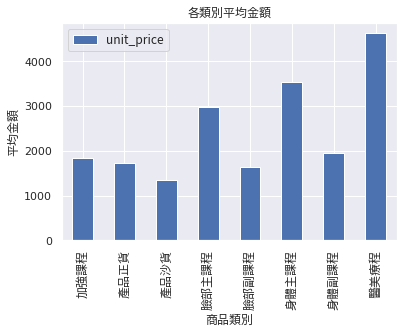

In [21]:
category_mean_price = df1.groupby(['categorydescription'])['unit_price'].mean()
category_mean_price

axes = category_mean_price.plot(kind='bar')
# 設定標頭和字體
plt.title('各類別平均金額',fontproperties=myfont)
# 設定 x 軸標頭和字體
plt.xlabel('商品類別',fontproperties=myfont)
# 設定 y 軸標頭和字體
plt.ylabel('平均金額', fontproperties=myfont)
# 設定右上角說明圖示字體
plt.legend(prop=myfont)

# 使用 for 迴圈一一取出 x 軸標籤 label 設定字體，若 y 軸有中文字也是類似使用方式 get_yticklabels
for label in axes.get_xticklabels():
    label.set_fontproperties(myfont)

plt.show()

# 2. BG/NBD Model

## 2.1 Train/Test Split

In [22]:
# train/test split (calibration/holdout)
t_holdout = 240                                         # days to reserve for holdout period

max_date = df1_train["sale_date"].max()                     # end date of observations
print("end of observations:", max_date)

max_cal_date = max_date - timedelta(days=t_holdout)     # end date of chosen calibration period
print("end of calibration period:", max_cal_date)

df_ch = calibration_and_holdout_data(
        transactions = df1_train, 
        customer_id_col = "member_code", 
        datetime_col = "sale_date",
        monetary_value_col = "Revenues", 
        calibration_period_end = max_cal_date, 
        observation_period_end = max_date, 
        freq = "D")  

print("customer behavior in calibration and holdout periods")
pd.options.display.float_format = '{:,.0f}'.format
df_ch

end of observations: 2019-12-31
end of calibration period: 2019-05-05
customer behavior in calibration and holdout periods


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
member_code,,,,,,,
9100000000060,1,44,95,"85,850",3,"2,576",240
9100000000084,0,0,165,0,1,"2,400",240
9100000000091,0,0,67,0,0,0,240
9100000000114,2,116,157,"9,717",3,"20,592",240
9100000000152,0,0,156,0,0,0,240
...,...,...,...,...,...,...,...
9100003054275,0,0,154,0,3,"18,345",240
9100003080267,0,0,19,0,1,480,240
9100003113064,10,106,158,"85,026",1,"4,455",240


In [23]:
df_ch.describe()


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,"38,662","38,662","38,662","38,662","38,662","38,662","38,662"
mean,2,47,113,"15,644",3,"5,273",240
std,3,59,55,"39,400",4,"14,874",0
min,0,0,0,0,0,0,240
25%,0,0,65,0,0,0,240
50%,1,8,126,600,1,709,240
75%,2,97,163,"9,860",4,"7,498",240
max,41,185,185,"1,776,885",74,"1,682,419",240


In [24]:
# training: frequency
pd.options.display.float_format = '{:,.3f}'.format
x = df_ch["frequency_cal"].value_counts(normalize=True)
x = x.nlargest(15)
print("frequency:")
x.sort_index(ascending=True)

frequency:


0.000    0.449
1.000    0.183
2.000    0.119
3.000    0.077
4.000    0.053
5.000    0.038
6.000    0.025
7.000    0.017
8.000    0.012
9.000    0.008
10.000   0.006
11.000   0.004
12.000   0.002
13.000   0.002
14.000   0.001
Name: frequency_cal, dtype: float64

In [25]:
# training: axis length
max_freq = df_ch["frequency_cal"].quantile(0.98)
max_rec = df_ch["recency_cal"].max()
max_T = df_ch["T_cal"].max()

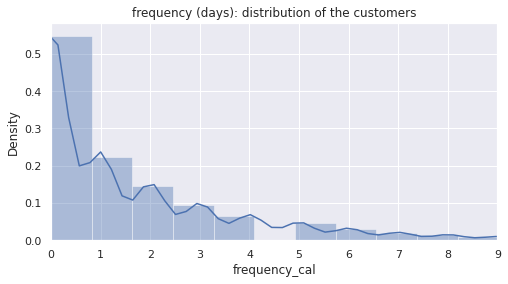

In [26]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["frequency_cal"])
ax.set_xlim(0, max_freq)
ax.set_title("frequency (days): distribution of the customers");

Text(0.5, 1.0, 'recency (days): distribution of the customers')

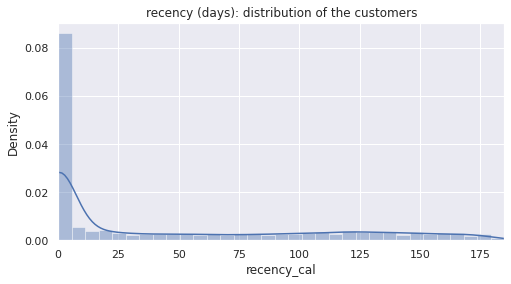

In [27]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["recency_cal"])
ax.set_xlim(0, max_rec)
ax.set_title("recency (days): distribution of the customers")

Text(0.5, 1.0, 'customer age T (days): distribution of the customers')

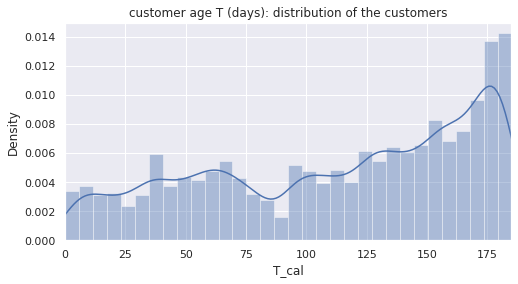

In [28]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["T_cal"])
ax.set_xlim(0, max_T)
ax.set_title("customer age T (days): distribution of the customers")

## 2.2 Fit the BG/NBD Model


In [29]:
# training: BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-03)
bgf.fit(
        frequency = df_ch["frequency_cal"], 
        recency = df_ch["recency_cal"], 
        T = df_ch["T_cal"],   
        weights = None,  
        verbose = True,   
        tol = 1e-03)

Optimization terminated successfully.
         Current function value: -0.397389
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20


<lifetimes.BetaGeoFitter: fitted with 38662 subjects, a: 0.14, alpha: 48.31, b: 1.24, r: 0.82>

In [30]:
# training: summary
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.825,0.012,0.801,0.848
alpha,48.308,0.872,46.599,50.018
a,0.138,0.008,0.122,0.153
b,1.243,0.067,1.113,1.374


<Figure size 864x864 with 0 Axes>

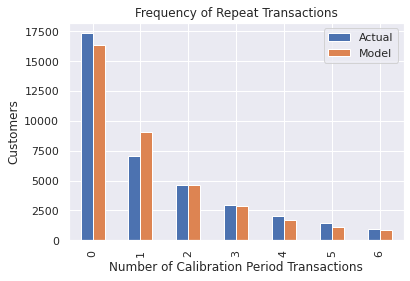

In [31]:
# training: does the model reflect the actual data closely enough?

# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

<Figure size 504x504 with 0 Axes>

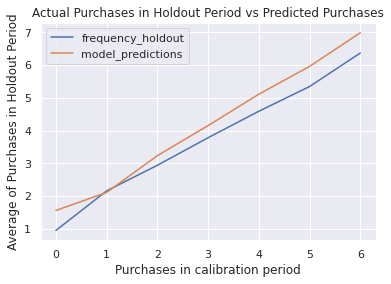

In [32]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch);

# 3. Fitting Model to Full Dataset


## 3.1 Customer Recency, Frequency, Age T, Monetary Value (Revenues) for Each Customer

In [33]:
max_date = df1_train["sale_date"].max()
# determine recency, frequency, T, monetary value for each customer
df_rft = summary_data_from_transaction_data(
    transactions = df1_train, 
    customer_id_col = "member_code", 
    datetime_col = "sale_date", 
    monetary_value_col = "Revenues", 
    observation_period_end = max_date, 
    freq = "D")

pd.options.display.float_format = '{:,.0f}'.format
df_rft

,frequency,recency,T,monetary_value
member_code,,,,
9100000000060,4,247,335,"24,682"
9100000000084,1,217,405,"7,200"
9100000000091,0,0,307,0
9100000000114,5,351,397,"32,716"
9100000000152,0,0,396,0
...,...,...,...,...
9100003128167,0,0,63,0
9100003140534,1,399,424,599
9100003151981,0,0,43,0


In [34]:
df_rft.describe()

,frequency,recency,T,monetary_value
count,"61,815","61,815","61,815","61,815"
mean,3,125,267,"15,034"
std,5,147,127,"34,154"
min,0,0,0,0
25%,0,0,167,0
50%,1,33,295,914
75%,4,262,382,"18,080"
max,92,425,425,"1,981,172"


## 3.2 Fitting the BG/NBD Model

In [35]:
# BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"],   
        weights = None,  
        verbose = True,   
        tol = 0.01)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -2.770009
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.468,0.003,0.462,0.475
alpha,38.235,0.418,37.416,39.054
a,0.027,0.001,0.025,0.029
b,0.214,0.006,0.201,0.226


In [36]:
#axis length
max_freq = int(df_rft["frequency"].max())  #quantile(0.95))          
max_T = int(df_rft["T"].max())                         
max_rec = int(df_rft["recency"].max())  
print(max_freq)

92


<Figure size 864x864 with 0 Axes>

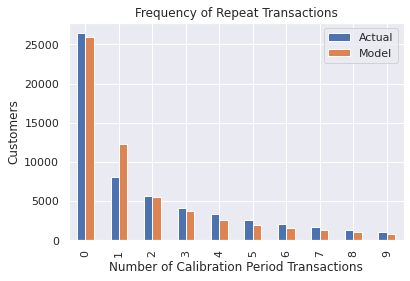

In [37]:
# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf,  
            max_frequency = 10);

## 3.3 Predictions

In [38]:
# helper function: plot expected number of future purchases a customer with 
#    frequency f and recency r will make in forecast period

def plot_freq_rec(t):
    fig = plt.figure(figsize=(7, 7)) 
    plot_frequency_recency_matrix(
            model = bgf,   
            T = t,  
            max_frequency = max_freq,  
            max_recency = max_rec);

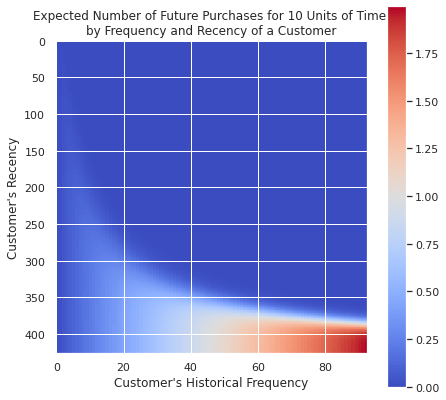

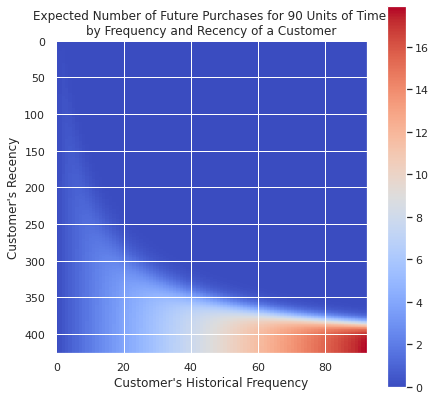

In [39]:
# call plotter function for different forecast periods:
tFC = [10, 90]
_ = [plot_freq_rec(t) for t in tFC]

In [40]:
# predict purchases for a selected customer for t days
t = 30
custID = 9100000000114

df_rft_C = df_rft.loc[custID,:]
predC = bgf.predict(    t, 
                        df_rft_C["frequency"], 
                        df_rft_C["recency"], 
                        df_rft_C["T"])
print("customer", custID, ": expected number of purchases within", t, "days =", f'{predC:.1f}')

customer 9100000000114 : expected number of purchases within 30 days = 0.4


In [41]:
# selected customer: transactions
df1C = df1[df1["member_code"] == custID]
df1C.describe()

,sales_qty,unit_price,Revenues
count,26.000,26.000,26.000
mean,2.654,"3,054.885","16,084.038"
std,2.979,"3,139.509","31,089.205"
min,1.000,155.000,155.000
25%,1.000,988.750,988.750
50%,1.000,"1,500.000","2,137.500"
75%,2.750,"3,553.500","9,556.500"
max,12.000,"10,000.000","116,400.000"


425


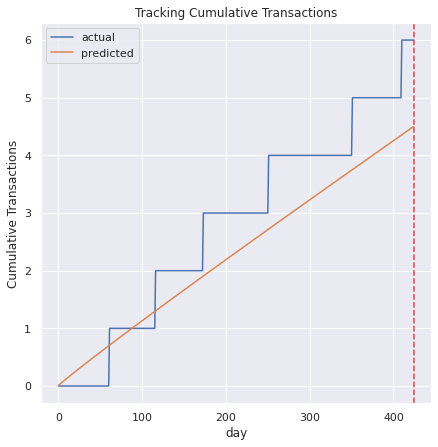

In [42]:
# X selected customer: cumulative transactions
max_date = df1_train["sale_date"].max()
min_date = df1_train["sale_date"].min()
span_days = (max_date - min_date).days
print(span_days)

fig = plt.figure(figsize=(7, 7)) 
plot_cumulative_transactions(
            model = bgf,  
            transactions = df1C, 
            datetime_col = "sale_date",  
            customer_id_col = "member_code",  
            t = span_days,  
            t_cal = span_days);

In [43]:
# helper function: predict each customer's purchases over next t days
def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
                bgf.predict(
                    t, 
                    df["frequency"], 
                    df["recency"], 
                    df["T"])

In [44]:
# call helper function: predict each customer's purchases over multiple time periods
t_FC = [10, 30, 60, 90]
_ = [predict_purch(df_rft, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("predicted number of purchases for each customer over next t days:")
df_rft

predicted number of purchases for each customer over next t days:


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
member_code,,,,,,,,
9100000000060,4.0,247.0,335.0,"24,682.5",0.1,0.3,0.7,1.0
9100000000084,1.0,217.0,405.0,"7,200.0",0.0,0.1,0.2,0.2
9100000000091,0.0,0.0,307.0,0.0,0.0,0.0,0.1,0.1
9100000000114,5.0,351.0,397.0,"32,716.2",0.1,0.4,0.7,1.1
9100000000152,0.0,0.0,396.0,0.0,0.0,0.0,0.1,0.1
...,...,...,...,...,...,...,...,...
9100003128167,0.0,0.0,63.0,0.0,0.0,0.1,0.3,0.4
9100003140534,1.0,399.0,424.0,599.0,0.0,0.1,0.2,0.3
9100003151981,0.0,0.0,43.0,0.0,0.1,0.2,0.3,0.5


In [45]:
# top 10 customers over next 30 days
print("top 10 customers, by their predicted purchases over next 30 days")
df_rft.sort_values(by="predict_purch_30", ascending=False).head(10)

top 10 customers, by their predicted purchases over next 30 days


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
member_code,,,,,,,,
9100000300535,92.0,401.0,402.0,"224,767.6",2.1,6.3,12.6,18.8
9100000063171,85.0,414.0,415.0,"397,785.6",1.9,5.7,11.3,16.9
9100002708179,24.0,96.0,104.0,"211,673.2",1.7,5.1,10.2,15.3
9100000024912,78.0,421.0,421.0,"101,779.4",1.7,5.1,10.2,15.3
9100001009604,72.0,401.0,416.0,"116,420.9",1.6,4.8,9.5,14.3
9100001543061,69.0,422.0,422.0,"126,468.9",1.5,4.5,9.0,13.5
9100000421681,61.0,395.0,398.0,"31,690.0",1.4,4.2,8.4,12.6
9100000031354,62.0,394.0,425.0,"31,093.5",1.3,3.9,7.8,11.7
9100000247519,57.0,424.0,424.0,"116,194.8",1.2,3.7,7.4,11.2


In [46]:
# recency, frequency, T
dfx = df1_train[df1_train["member_code"] == 9100000247519]
xmax_date = dfx["sale_date"].max()
xmin_date = dfx["sale_date"].min()

# recency:
print("customer minimum date:", xmin_date)
print("customer maximum date:", xmax_date)
xrec = (xmax_date - xmin_date).days
print("recency:", xrec)                                    # recency = time span between first and last purchase

# age T:
xmaxall_date = df1["sale_date"].max()
print("population maximum date:", xmaxall_date)
xage = (xmaxall_date - xmin_date).days                    # age T
print("T:", xage)

# frequency:
xfreq = len(dfx[dfx["sales_qty"] > 0].groupby("sale_date"))-1    # frequency: periods with repeat purchases
print("frequency:", xfreq)

customer minimum date: 2018-11-02
customer maximum date: 2019-12-31
recency: 424
population maximum date: 2021-06-30
T: 971
frequency: 57


predicted average number of customer purchases over next 90 days:


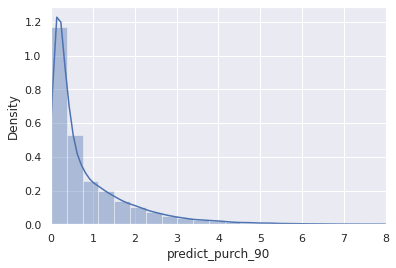

In [47]:
print("predicted average number of customer purchases over next 90 days:")
ax = sns.distplot(df_rft["predict_purch_90"]).set_xlim(0,8)

In [48]:
# helper function: probability of n repeat purchases within t days
def prob_purch(t, n):
    p = bgf.probability_of_n_purchases_up_to_time(t, n)
    return p

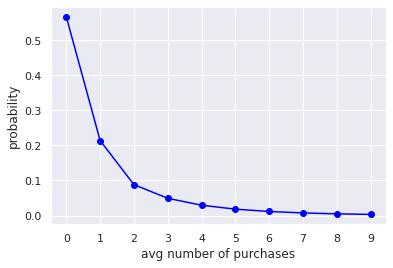

In [49]:
# call helper function: probability of n repeat purchases within t days
t = 90                  # forecast period, days
purch = range(0,10,1)   # number of repeat purchases 
probs = [prob_purch(t,n) for n in purch]

dict_probs = dict(zip(purch, probs))
#_ = [print(k,":",f'{v:.2f}') for k,v in dict_probs.items()]

plt.plot(purch, probs, '-o', color='blue')
plt.xlabel("avg number of purchases")
plt.ylabel("probability")
plt.xticks(purch)
plt.show()

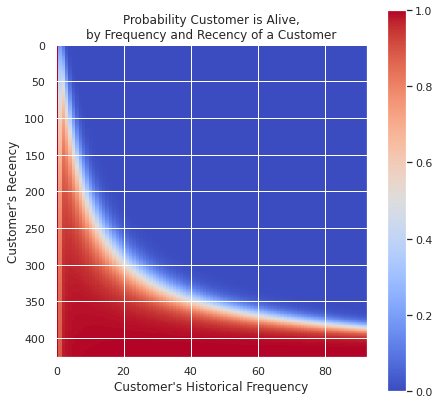

In [50]:
# probability that a customer has not churned (= is alive), based on 
# customer's specific recency r and frequency f
fig = plt.figure(figsize=(7, 7)) 
plot_probability_alive_matrix(
            model = bgf,  
            max_frequency = max_freq,  
            max_recency = max_rec);

In [51]:
# probability that a customer is alive for each customer in dataframe
prob_alive = bgf.conditional_probability_alive(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"])

df_rft["prob_alive"] = prob_alive
pd.options.display.float_format = '{:,.2f}'.format
df_rft.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
count,"61,815.00","61,815.00","61,815.00","61,815.00","61,815.00","61,815.00","61,815.00","60,795.00","61,815.00"
mean,3.02,125.35,267.45,"15,033.84",0.10,0.29,0.58,0.87,0.92
std,4.94,146.69,126.62,"34,153.63",0.12,0.35,0.71,1.07,0.17
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,167.00,0.00,0.02,0.06,0.12,0.17,0.95
50%,1.00,33.00,295.00,914.00,0.05,0.15,0.29,0.42,0.99
75%,4.00,262.00,382.00,"18,079.97",0.13,0.39,0.78,1.18,1.00
max,92.00,425.00,425.00,"1,981,171.67",2.10,6.29,12.58,18.85,1.00


In [52]:
# show customers who are alive, but with less than 90% certainty
df_rft[df_rft["prob_alive"] > 0.9]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
member_code,,,,,,,,,
9100000000060,4.00,247.00,335.00,"24,682.50",0.12,0.35,0.70,1.04,0.97
9100000000091,0.00,0.00,307.00,0.00,0.01,0.04,0.08,0.12,1.00
9100000000114,5.00,351.00,397.00,"32,716.20",0.12,0.37,0.74,1.11,0.99
9100000000152,0.00,0.00,396.00,0.00,0.01,0.03,0.06,0.10,1.00
9100000000213,0.00,0.00,29.00,0.00,0.07,0.20,0.40,0.59,1.00
...,...,...,...,...,...,...,...,...,...
9100003113064,11.00,336.00,398.00,"78,511.00",0.26,0.78,1.55,2.32,0.98
9100003128167,0.00,0.00,63.00,0.00,0.05,0.14,0.27,0.40,1.00
9100003151981,0.00,0.00,43.00,0.00,0.06,0.17,0.33,0.49,1.00


In [53]:
# pick a customer
custID = 9100000000114
df_rft[df_rft.index == custID]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
member_code,,,,,,,,,
9100000000114,5.00,351.00,397.00,"32,716.20",0.12,0.37,0.74,1.11,0.99


In [54]:
# select a customer

custID = 9100000000114

df1C = df1[df1["member_code"] == custID]
df1C.describe()

,sales_qty,unit_price,Revenues
count,26.00,26.00,26.00
mean,2.65,"3,054.88","16,084.04"
std,2.98,"3,139.51","31,089.20"
min,1.00,155.00,155.00
25%,1.00,988.75,988.75
50%,1.00,"1,500.00","2,137.50"
75%,2.75,"3,553.50","9,556.50"
max,12.00,"10,000.00","116,400.00"


customer 9100000000114 : probability of being alive over time


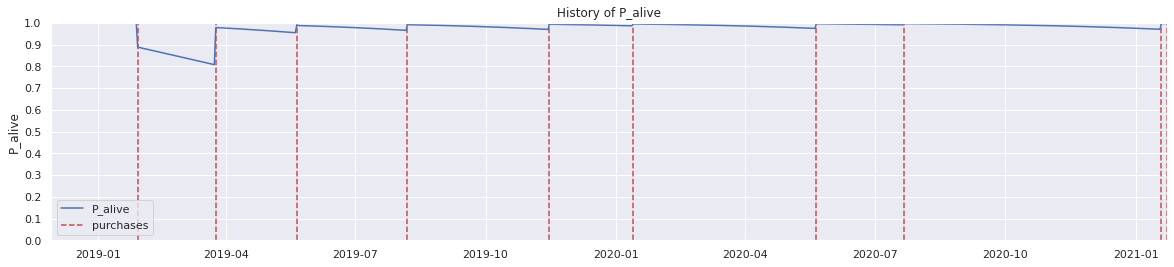

In [55]:
# history of the selected customer: probability over time of being alive
fig = plt.figure(figsize=(20,4))
print("customer",custID,": probability of being alive over time")
plot_history_alive(
                    model = bgf, 
                    t = span_days, 
                    transactions = df1C, 
                    datetime_col = "sale_date");

In [56]:
# selected customer's probability of being alive - development over time
path_alive = calculate_alive_path(
            model = bgf, 
            t = span_days, 
            transactions = df1C, 
            datetime_col = "sale_date");
print("customer",custID,"'s probability of being alive, development over time")
path_alive.explode().astype(np.float64).describe()

customer 9100000000114 's probability of being alive, development over time


count   787.00
mean      0.98
std       0.04
min       0.81
25%       0.98
50%       0.99
75%       0.99
max       1.00
dtype: float64

# 4. Customer Segmentation


In [57]:
df_rft1 = df_rft.copy()
df_rft1

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
member_code,,,,,,,,,
9100000000060,4.00,247.00,335.00,"24,682.50",0.12,0.35,0.70,1.04,0.97
9100000000084,1.00,217.00,405.00,"7,200.00",0.03,0.08,0.15,0.23,0.78
9100000000091,0.00,0.00,307.00,0.00,0.01,0.04,0.08,0.12,1.00
9100000000114,5.00,351.00,397.00,"32,716.20",0.12,0.37,0.74,1.11,0.99
9100000000152,0.00,0.00,396.00,0.00,0.01,0.03,0.06,0.10,1.00
...,...,...,...,...,...,...,...,...,...
9100003128167,0.00,0.00,63.00,0.00,0.05,0.14,0.27,0.40,1.00
9100003140534,1.00,399.00,424.00,599.00,0.03,0.08,0.17,0.25,0.88
9100003151981,0.00,0.00,43.00,0.00,0.06,0.17,0.33,0.49,1.00


## 4.1 Clustering by kmeans 

In [58]:
#function for ordering cluster numbers
#把cluster做排序
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

### 4.1.1 Recency

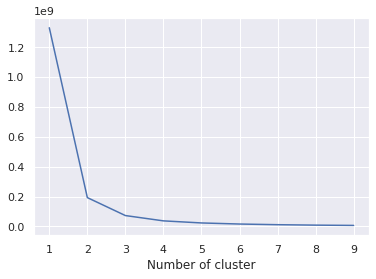

In [59]:
from sklearn.cluster import KMeans

sse={}
tx_recency = df_rft1[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()


In [60]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_rft1[['recency']])
df_rft1['RecencyCluster'] = kmeans.predict(df_rft1[['recency']])

df_rft1 = order_cluster('RecencyCluster', 'recency',df_rft1,False)

df_rft1.groupby('RecencyCluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,"11,158.00",367.18,29.80,313.00,343.00,367.00,392.00,425.00
1,"9,147.00",257.84,32.87,198.00,230.00,259.00,287.00,312.00
2,"8,167.00",135.72,36.43,71.00,105.00,136.00,167.00,197.00
3,"33,343.00",5.54,14.38,0.00,0.00,0.00,0.00,70.00


### 4.1.2 Frequency

In [61]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_rft1[['frequency']])
df_rft1['FrequencyCluster'] = kmeans.predict(df_rft1[['frequency']])

#order the frequency cluster
df_rft1 = order_cluster('FrequencyCluster', 'frequency',df_rft1,True)

#see details of each cluster
df_rft1.groupby('FrequencyCluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,"40,285.00",0.49,0.73,0.00,0.00,0.00,1.00,2.00
1,"15,048.00",4.85,1.63,3.00,3.00,5.00,6.00,8.00
2,"5,265.00",12.04,2.66,9.00,10.00,11.00,14.00,18.00
3,"1,217.00",25.25,7.75,19.00,20.00,23.00,27.00,92.00


### 4.1.3 Monetary

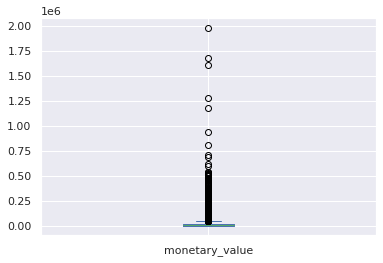

In [62]:
df_rft1['monetary_value'].plot.box()


In [63]:
def Outlier_treatment(datacolumn):
  Q1,Q3 = np.percentile(datacolumn,[25,75])
  IQR = Q3-Q1
  lower_range = Q1 - (1.5 * IQR)
  high_range = Q3 + (1.5 * IQR)
  return lower_range,high_range

lowerbound,highbound = Outlier_treatment(df_rft1['monetary_value'])

#df_rft.drop(df_rft[(df_rft['monetary_value'] < lowerbound) | (df_rft['monetary_value']>highbound)],inplace=True)
df_rft1 = df_rft1[(df_rft1['monetary_value'] < highbound)]


In [64]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_rft1[['monetary_value']])
df_rft1['RevenueCluster'] = kmeans.predict(df_rft1[['monetary_value']])


#order the cluster numbers
df_rft1 = order_cluster('RevenueCluster', 'monetary_value',df_rft1,True)
#show details of the dataframe
df_rft1.groupby('RevenueCluster')['monetary_value'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,"40,234.00",653.15,"1,293.69",0.00,0.00,0.00,740.00,"6,200.00"
1,"6,071.00","11,720.08","3,429.43","6,206.29","8,723.50","11,479.75","14,762.25","17,916.00"
2,"4,692.00","24,049.12","3,683.91","17,929.00","20,858.92","23,932.26","27,188.74","30,767.67"
3,"3,961.00","37,418.83","4,072.71","30,778.25","33,878.00","37,077.00","40,750.12","45,196.75"


## 4.2 Segmentation 

### 4.2.1 Total score


In [65]:
#calculate overall score and use mean() to see details
#tx_user1
df_rft1['OverallScore'] = df_rft1['RecencyCluster'] + df_rft1['FrequencyCluster'] + df_rft1['RevenueCluster']


print(df_rft1.groupby('OverallScore')['recency'].mean())
print(df_rft1.groupby('OverallScore')['frequency'].mean())
print(df_rft1.groupby('OverallScore')['monetary_value'].mean())


OverallScore
0   354.25
1   298.56
2   217.53
3    36.70
4   218.26
5   243.84
6   188.55
7    84.95
8    70.00
Name: recency, dtype: float64
OverallScore
0    1.56
1    2.89
2    3.26
3    0.91
4    6.21
5    8.49
6    9.46
7    6.71
8   13.00
Name: frequency, dtype: float64
OverallScore
0    1,719.10
1    2,385.31
2    4,286.47
3    1,807.82
4   19,759.77
5   30,601.70
6   35,485.06
7   37,643.71
8   39,736.15
Name: monetary_value, dtype: float64


### 4.2.2  Labeling

In [66]:
df_rft1['Segment'] = 'Low-Value'
df_rft1.loc[df_rft1['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_rft1.loc[df_rft1['OverallScore']>4,'Segment'] = 'High-Value' 
df_rft1

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,RecencyCluster,FrequencyCluster,RevenueCluster,OverallScore,Segment
0,4.00,247.00,335.00,"24,682.50",0.12,0.35,0.70,1.04,0.97,1,1,2,4,Mid-Value
1,3.00,278.00,314.00,"29,129.33",0.10,0.29,0.58,0.87,0.98,1,1,2,4,Mid-Value
2,3.00,209.00,271.00,"19,110.33",0.11,0.33,0.65,0.98,0.97,1,1,2,4,Mid-Value
3,4.00,309.00,423.00,"19,409.25",0.09,0.28,0.56,0.84,0.97,1,1,2,4,Mid-Value
4,7.00,223.00,424.00,"24,464.14",0.12,0.37,0.74,1.11,0.77,1,1,2,4,Mid-Value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54953,23.00,345.00,412.00,"35,092.39",0.49,1.48,2.96,4.44,0.95,0,3,3,6,High-Value
54954,19.00,401.00,402.00,"35,921.89",0.44,1.32,2.64,3.96,1.00,0,3,3,6,High-Value
54955,38.00,357.00,359.00,"38,734.37",0.97,2.90,5.79,8.68,1.00,0,3,3,6,High-Value
54956,25.00,326.00,341.00,"43,180.40",0.67,2.01,4.01,6.01,1.00,0,3,3,6,High-Value


### 4.2.3  Plot - Customer Segmentation

In [67]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
df_rft1['Segment_'] = labelencoder.fit_transform(df_rft1['Segment'])
df_rft1


df_rft_RFM = df_rft1[['frequency','recency','monetary_value']]
df_rft_RFM = df_rft_RFM.to_numpy()
df_rft_RFM


array([[    4.  ,   247.  , 24682.5 ],
       [    3.  ,   278.  , 29129.33],
       [    3.  ,   209.  , 19110.33],
       ...,
       [   38.  ,   357.  , 38734.37],
       [   25.  ,   326.  , 43180.4 ],
       [   20.  ,   317.  , 35372.9 ]])

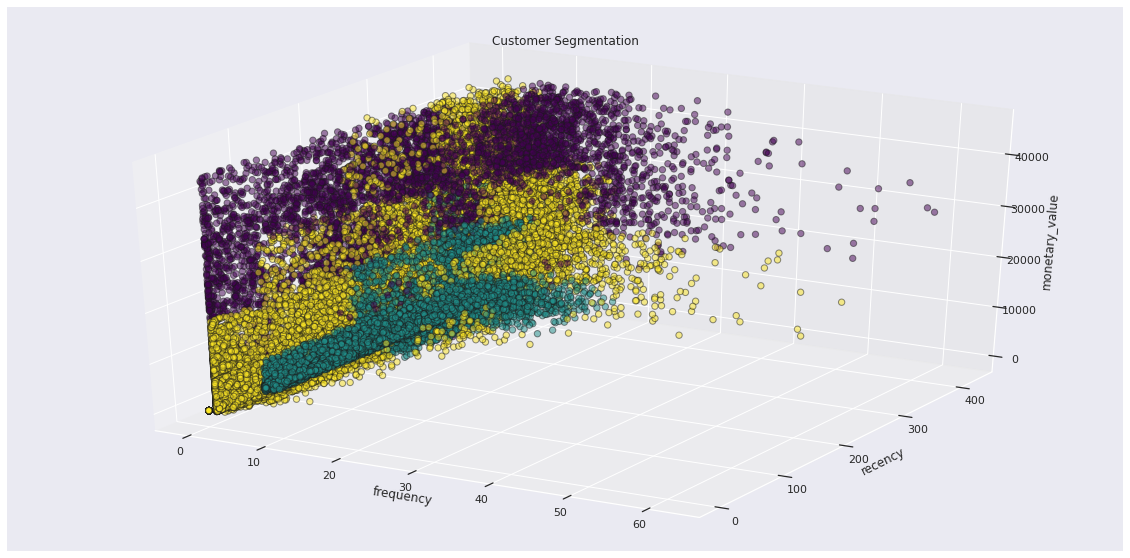

In [68]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
df_rft_RFM
ax.scatter(df_rft_RFM[:,0],df_rft_RFM[:,1],df_rft_RFM[:,2], 
            c=df_rft1['Segment_'].to_numpy(), cmap='viridis',
            edgecolor='k', s=40, alpha = 0.5)


ax.set_title("Customer Segmentation")
ax.set_xlabel("frequency")
ax.set_ylabel("recency")
ax.set_zlabel("monetary_value")
ax.dist = 10

#ax.scatter(kmeans_PCA.cluster_centers_[:,0], kmeans_PCA.cluster_centers_[:,1], 
#           kmeans_PCA.cluster_centers_[:,2], 
#           s = 300, c = 'r', marker='*', label = 'Centroid')

plt.autoscale(enable=True, axis='x', tight=True)    

plt.show()

### 4.2.4  Plot - prob_alive and Customer Segmentation

In [69]:
df_rft1

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,RecencyCluster,FrequencyCluster,RevenueCluster,OverallScore,Segment,Segment_
0,4.00,247.00,335.00,"24,682.50",0.12,0.35,0.70,1.04,0.97,1,1,2,4,Mid-Value,2
1,3.00,278.00,314.00,"29,129.33",0.10,0.29,0.58,0.87,0.98,1,1,2,4,Mid-Value,2
2,3.00,209.00,271.00,"19,110.33",0.11,0.33,0.65,0.98,0.97,1,1,2,4,Mid-Value,2
3,4.00,309.00,423.00,"19,409.25",0.09,0.28,0.56,0.84,0.97,1,1,2,4,Mid-Value,2
4,7.00,223.00,424.00,"24,464.14",0.12,0.37,0.74,1.11,0.77,1,1,2,4,Mid-Value,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54953,23.00,345.00,412.00,"35,092.39",0.49,1.48,2.96,4.44,0.95,0,3,3,6,High-Value,0
54954,19.00,401.00,402.00,"35,921.89",0.44,1.32,2.64,3.96,1.00,0,3,3,6,High-Value,0
54955,38.00,357.00,359.00,"38,734.37",0.97,2.90,5.79,8.68,1.00,0,3,3,6,High-Value,0
54956,25.00,326.00,341.00,"43,180.40",0.67,2.01,4.01,6.01,1.00,0,3,3,6,High-Value,0


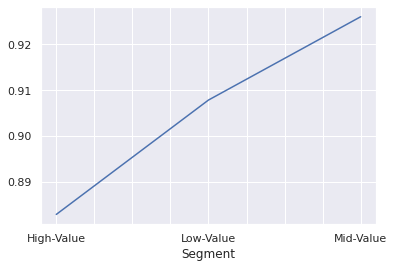

In [70]:
df_rft1_ = df_rft1.groupby(['Segment'])['prob_alive'].mean()
df_rft1_.plot()
plt.show()


# 5 Customer Lifetime Value: The Gamma-Gamma Model


## 5.1 Fitting the Gamma-Gamma Model


In [71]:
# select customers with monetary value > 0
df_rftv = df_rft[df_rft["monetary_value"] > 0]
pd.options.display.float_format = '{:,.2f}'.format
df_rftv.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
count,"35,019.00","35,019.00","35,019.00","35,019.00","35,019.00","35,019.00","35,019.00","35,019.00","35,019.00"
mean,5.32,220.19,316.16,"26,537.51",0.15,0.45,0.90,1.35,0.86
std,5.56,130.42,103.40,"41,878.08",0.13,0.40,0.80,1.20,0.21
min,1.00,1.00,1.00,19.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,105.00,259.00,"2,165.94",0.06,0.17,0.33,0.50,0.82
50%,3.00,236.00,351.00,"13,673.00",0.11,0.34,0.68,1.02,0.97
75%,7.00,339.00,401.00,"37,366.65",0.20,0.61,1.22,1.82,0.99
max,92.00,425.00,425.00,"1,981,171.67",2.10,6.29,12.58,18.85,1.00


In [72]:
# Gamma-Gamma model requires a Pearson correlation close to 0 
# between purchase frequency and monetary value

corr_matrix = df_rftv[["monetary_value", "frequency"]].corr()
corr = corr_matrix.iloc[1,0]
print("Pearson correlation: %.3f" % corr)

Pearson correlation: 0.188


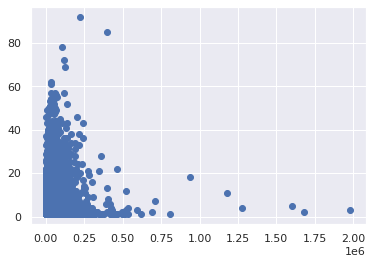

In [73]:
dfx = df_rftv["monetary_value"]
dfy = df_rftv["frequency"]
plt.scatter(dfx, dfy)

In [74]:

# outlier
df_rftv[df_rftv["monetary_value"] == df_rftv["monetary_value"].max()]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
member_code,,,,,,,,,
9100000213941,3.00,255.00,271.00,"1,981,171.67",0.11,0.33,0.66,0.99,0.99


In [75]:
# fitting the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(
        frequency = df_rftv["frequency"],
        monetary_value = df_rftv["monetary_value"],  
        weights = None,   
        verbose = True,  
        tol = 1e-06,  
        q_constraint = True)
pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,0.245,0.002,0.241,0.249
q,4.172,0.121,3.935,4.410
v,"415,886.404","17,357.665","381,865.380","449,907.427"


## 5.2 Predictions

In [76]:
# estimate the average transaction value of each customer, based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
        df_rftv["frequency"],
        df_rftv["monetary_value"])

df_rftv["exp_avg_rev"] = exp_avg_rev
df_rftv["avg_rev"] = df_rftv["monetary_value"]
df_rftv["error_rev"] = df_rftv["exp_avg_rev"] - df_rftv["avg_rev"]


mape = mean_absolute_percentage_error(exp_avg_rev, df_rftv["monetary_value"])
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_rftv.head()

MAPE of predicted revenues: 0.64


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
member_code,,,,,,,,,,,,
9100000000060,4.000,247.000,335.000,"24,682.500",0.116,0.349,0.697,1.044,0.973,"30,395.780","24,682.500","5,713.280"
9100000000084,1.000,217.000,405.000,"7,200.000",0.026,0.077,0.154,0.231,0.780,"30,371.182","7,200.000","23,171.182"
9100000000114,5.000,351.000,397.000,"32,716.200",0.124,0.372,0.744,1.114,0.988,"32,317.376","32,716.200",-398.824
9100000000220,1.000,153.000,283.000,"1,462.000",0.036,0.108,0.215,0.322,0.788,"29,959.281","1,462.000","28,497.281"
9100000000237,2.000,271.000,424.000,"2,070.000",0.050,0.151,0.302,0.452,0.944,"28,132.065","2,070.000","26,062.065"


In [77]:
# compute customer lifetime value
DISCOUNT_a = 0.06                # annual discount rate
LIFE = 12                        # lifetime expected for the customers in months

discount_m = (1 + DISCOUNT_a)**(1/12) - 1     # monthly discount rate

clv = ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,  
        frequency = df_rftv["frequency"],  
        recency = df_rftv["recency"],  
        T = df_rftv["T"],  
        monetary_value = df_rftv["monetary_value"],  
        time = LIFE,    
        freq = "D",                          
        discount_rate = discount_m)

df_rftv.insert(0, "CLV", clv)             # expected customer lifetime values
df_rftv.describe().T

,count,mean,std,min,25%,50%,75%,max
CLV,"35,019.000","177,522.494","286,236.593",2.035,"57,609.732","116,169.501","213,424.521","22,786,965.674"
frequency,"35,019.000",5.316,5.562,1.000,2.000,3.000,7.000,92.000
recency,"35,019.000",220.187,130.415,1.000,105.000,236.000,339.000,425.000
T,"35,019.000",316.155,103.404,1.000,259.000,351.000,401.000,425.000
monetary_value,"35,019.000","26,537.509","41,878.081",19.000,"2,165.938","13,673.000","37,366.650","1,981,171.667"
predict_purch_10,"35,019.000",0.150,0.134,0.000,0.056,0.114,0.203,2.099
predict_purch_30,"35,019.000",0.450,0.402,0.000,0.168,0.342,0.610,6.293
predict_purch_60,"35,019.000",0.898,0.803,0.000,0.335,0.683,1.218,12.576
predict_purch_90,"35,019.000",1.345,1.203,0.000,0.502,1.023,1.824,18.848
prob_alive,"35,019.000",0.861,0.207,0.000,0.825,0.967,0.989,1.000


In [78]:
df_rftv.sort_values(by="CLV", ascending=False)


,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
member_code,,,,,,,,,,,,,
9100000063171,"22,786,965.674",85.000,414.000,415.000,"397,785.612",1.884,5.650,11.291,16.922,1.000,"349,509.662","397,785.612","-48,275.950"
9100000300535,"14,596,338.311",92.000,401.000,402.000,"224,767.587",2.099,6.293,12.576,18.848,1.000,"201,033.066","224,767.587","-23,734.521"
9100000624389,"12,003,389.528",18.000,209.000,250.000,"936,340.278",0.624,1.870,3.735,5.595,0.974,"558,348.539","936,340.278","-377,991.738"
9100002708179,"8,705,442.083",24.000,96.000,104.000,"211,673.167",1.710,5.122,10.219,15.295,0.995,"148,821.143","211,673.167","-62,852.023"
9100001584002,"6,908,024.902",43.000,376.000,377.000,"238,853.930",1.046,3.135,6.265,9.389,0.999,"191,069.297","238,853.930","-47,784.633"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100002598343,258.334,6.000,30.000,362.000,999.667,0.000,0.001,0.002,0.003,0.002,"22,285.937",999.667,"21,286.270"
9100000190952,246.149,8.000,61.000,369.000,110.125,0.000,0.001,0.002,0.003,0.002,"19,911.946",110.125,"19,801.821"
9100002567226,224.345,6.000,38.000,416.000,"7,299.000",0.000,0.001,0.002,0.002,0.002,"24,282.501","7,299.000","16,983.501"


## 5.3 CLV Clustering

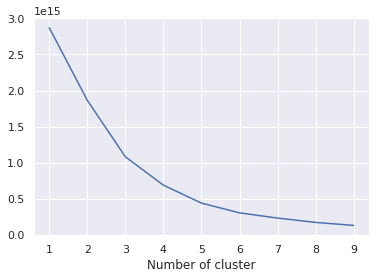

In [79]:
from sklearn.cluster import KMeans

sse={}
tx_recency = df_rftv[['CLV']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

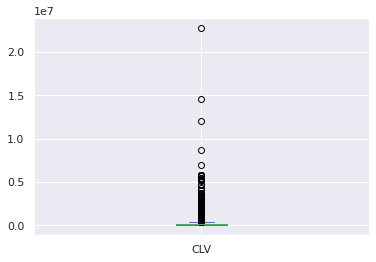

In [81]:
df_rftv['CLV'].plot.box()

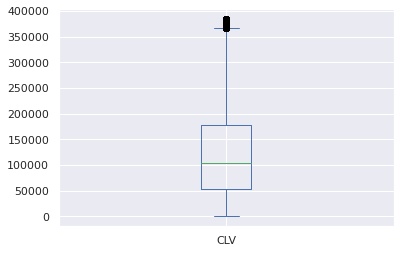

In [83]:

lowerbound,highbound = Outlier_treatment(df_rftv['CLV'])

#df_rft.drop(df_rft[(df_rft['monetary_value'] < lowerbound) | (df_rft['monetary_value']>highbound)],inplace=True)
df_rftv = df_rftv[(df_rftv['CLV'] < highbound)]

df_rftv['CLV'].plot.box()

In [86]:
#build 4 clusters for CLV and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_rftv[['CLV']])
df_rftv['CLVCluster'] = kmeans.predict(df_rftv[['CLV']])

df_rftv = order_cluster('CLVCluster', 'CLV',df_rftv,True)

df_rftv.groupby('CLVCluster')['CLV'].describe()

,count,mean,std,min,25%,50%,75%,max
CLVCluster,,,,,,,,
0,"15,733.000","53,572.427","27,248.091",2.035,"30,497.094","52,612.951","76,785.266","102,282.574"
1,"10,747.000","151,326.431","32,437.121","102,308.996","123,103.140","146,914.834","177,555.663","217,012.095"
2,"5,360.000","283,182.527","46,086.957","217,037.873","243,908.104","274,836.325","318,430.943","385,076.584"


## 5.4 Correlation

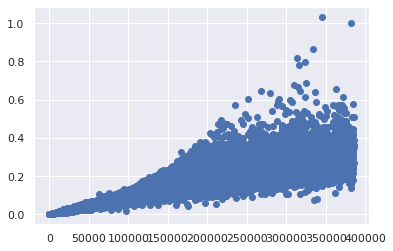

In [88]:
dfx = df_rftv["CLV"]
dfy = df_rftv["predict_purch_10"]
plt.scatter(dfx, dfy)

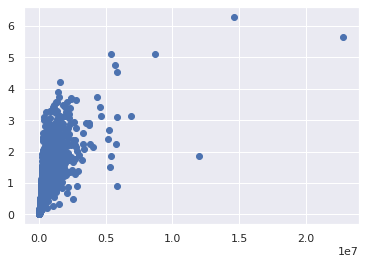

In [170]:
dfx = df_rftv["CLV"]
dfy = df_rftv["predict_purch_30"]
plt.scatter(dfx, dfy)

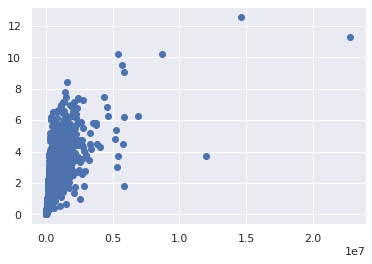

In [171]:
dfx = df_rftv["CLV"]
dfy = df_rftv["predict_purch_60"]
plt.scatter(dfx, dfy)

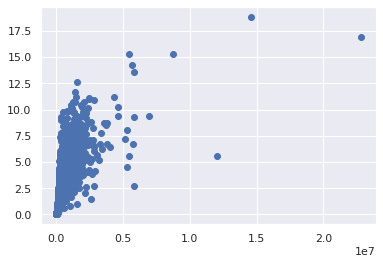

In [172]:
dfx = df_rftv["CLV"]
dfy = df_rftv["predict_purch_90"]
plt.scatter(dfx, dfy)

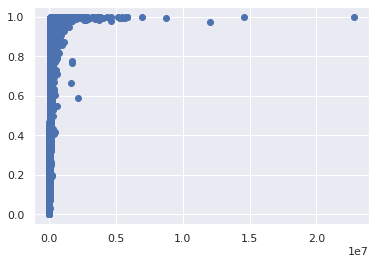

In [181]:
dfx = df_rftv["CLV"]
dfy = df_rftv["prob_alive"]
plt.scatter(dfx, dfy)

# 6 Parameter Distributions

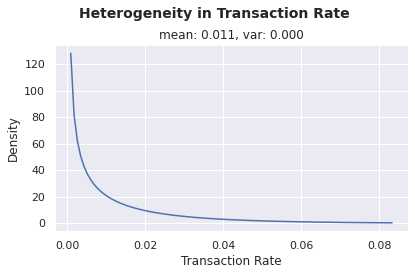

In [ ]:
# Gamma distribution of lambda: customers' propensitiy to purchase
plot_transaction_rate_heterogeneity(model = bgf)   

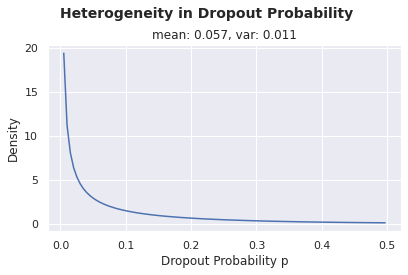

In [ ]:
# Beta distribution of p: customer's probability of dropping out immediately after a transaction
plot_dropout_rate_heterogeneity(model = bgf)